In this notebook, I implement Deep Successor Reinforcement Learning by Tejas D. Kulkarni, Ardavan Saeedi, Simanta Gautam, Samuel J. Gershman. ([link](https://arxiv.org/abs/1606.02396))

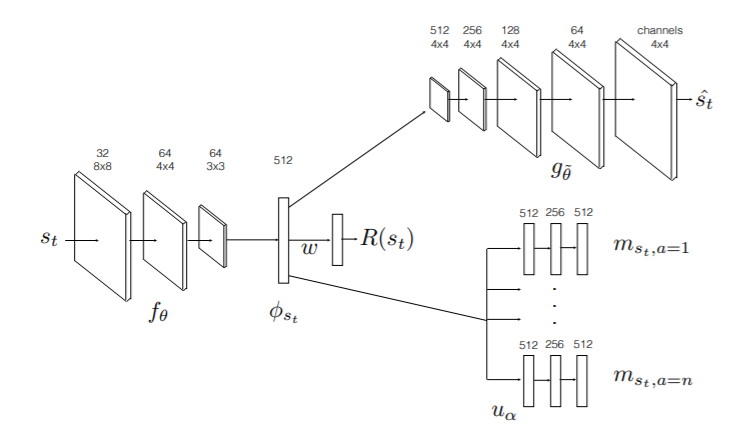

### Implementing the environment

In [1]:
import numpy as np
k = 10
print(f'k = {k}')

k = 10


In [2]:
"""
Environment where you have a linear states that's risky. Wrong action and you get to the start with a negative reward. 
Written by modifying y_chain.py
"""


import gym
from gym import spaces
from gym.utils import seeding
from gym.envs.registration import register
import numpy as np

class GridWorld():
    """
    """
    def __init__(self, n=10, R=np.zeros(100), T=np.hstack((np.zeros(15), np.ones(1)))):

        # Initialzing required parameters
        self.update_count = 0
        self.n = n # size of grid world
        self.R = R # storing the rewards in this vector
        self.T = T # storing boolean values of terminal states
        self.state = 0  # Start at beginning of the chain (bottom left)
        self.action_space = spaces.Discrete(4) # Number of actions: 4 - [0: up, 1: right, 2: left, 3: down]
        self.observation_space = spaces.Discrete(self.n * self.n) # number of states is equal to area of gridworld
        
        # Setting reward values
        self.step_reward = 0
        self.final_reward = 1
        
        self.seed() # not sure what this does, so not changing it

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        '''
        takes an action as an argument and returns the next_state, reward, done, info.
        '''
        
        # Making sure valid action is chosen
        assert self.action_space.contains(action)
        
        done = False
        self.update_count += 1
        
        if(self.check_walls(action) == True): # you hit a wall
            return self.state, self.R[self.state], done, {}
            
        # Stepping along on the chain
        if(action == 0):
            self.state = self.state + self.n
        elif(action == 1):
            self.state = self.state + 1
        elif(action == 2):
            self.state = self.state - self.n
        else:
            self.state = self.state - 1

        # Because this is a continuing case
        if(self.T[self.state] == 1):
            done = True

        return self.state, self.R[self.state], done, {}
        
    
    def check_walls(self, action):
        if((self.state < self.n) and (action == 2)): # you hit bottom wall
            return True
        elif((self.state >= self.n*(self.n-1)) and (action == 0)): # you hit upper wall
            return True
        elif(((self.state % self.n) == 0) and (action == 3)): # hit left wall
            return True
        elif(((self.state % self.n) == (self.n-1)) and (action == 1)): # you hit right wall
            return True
        return False        

    def plot(self):
        print(f'state = {self.state}')
        for j in range(self.n-1, -1, -1):
            for i in range(0, self.n):
                if(i+self.n*j == self.state):
                    print('H', end = ' ')
                elif(not self.R[i+self.n*j]==0):
                    print('G', end=' ')
                else:
                    print('o', end = ' ')
            print(' ')
        pass
    
    def reset(self):
        '''
        transitions back to first state
        '''
        self.update_count = 0 
        self.state = 0
        return self.state

In [3]:
env = GridWorld(R=np.zeros(100))
env.plot()

state = 0
o o o o o o o o o o  
o o o o o o o o o o  
o o o o o o o o o o  
o o o o o o o o o o  
o o o o o o o o o o  
o o o o o o o o o o  
o o o o o o o o o o  
o o o o o o o o o o  
o o o o o o o o o o  
H o o o o o o o o o  


### implementing neural network in torch for FA

In [4]:
# Importing torch related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Defining a neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, kernel_size=5, stride=2)
        self.fc1 = nn.Linear(1, 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x
    
net = Net()
print(net, net.parameters)

Net(
  (conv1): Conv2d(1, 3, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=1, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
) <bound method Module.parameters of Net(
  (conv1): Conv2d(1, 3, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=1, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
)>


### Setting up gridworld envir

In [8]:
import random
import numpy as np
import gym
from gym_minigrid.register import env_list
from gym_minigrid.minigrid import Grid, OBJECT_TO_IDX

# Test specifically importing a specific environment
from gym_minigrid.envs import DoorKeyEnv

# Test importing wrappers
from gym_minigrid.wrappers import *

##############################################################################

print('%d environments registered' % len(env_list))

for env_name in env_list:
    print('testing "%s"' % env_name)

    # Load the gym environment
    env = gym.make(env_name)
    env.max_steps = min(env.max_steps, 200)
    env.reset()
    env.render('rgb_array')

    # Verify that the same seed always produces the same environment
    for i in range(0, 5):
        seed = 1337 + i
        env.seed(seed)
        grid1 = env.grid
        env.seed(seed)
        grid2 = env.grid
        assert grid1 == grid2

    env.reset()

    # Run for a few episodes
    num_episodes = 0
    while num_episodes < 5:
        # Pick a random action
        action = random.randint(0, env.action_space.n - 1)

        obs, reward, done, info = env.step(action)

        # Validate the agent position
        assert env.agent_pos[0] < env.width
        assert env.agent_pos[1] < env.height

        # Test observation encode/decode roundtrip
        img = obs['image']
        vis_mask = img[:, :, 0] != OBJECT_TO_IDX['unseen']  # hackish
        img2 = Grid.decode(img).encode(vis_mask=vis_mask)
        assert np.array_equal(img, img2)

        # Test the env to string function
        str(env)

        # Check that the reward is within the specified range
        assert reward >= env.reward_range[0], reward
        assert reward <= env.reward_range[1], reward

        if done:
            num_episodes += 1
            env.reset()

        env.render('rgb_array')
        break

    # Test the close method
    env.close()

    env = gym.make(env_name)
    env = ReseedWrapper(env)
    for _ in range(10):
        env.reset()
        env.step(0)
        env.close()

    env = gym.make(env_name)
    env = ImgObsWrapper(env)
    env.reset()
    env.step(0)
    env.close()

    # Test the fully observable wrapper
    env = gym.make(env_name)
    env = FullyObsWrapper(env)
    env.reset()
    obs, _, _, _ = env.step(0)
    assert obs.shape == env.observation_space.shape
    env.close()

    env = gym.make(env_name)
    env = FlatObsWrapper(env)
    env.reset()
    env.step(0)
    env.close()

    env = gym.make(env_name)
    env = AgentViewWrapper(env, 5)
    env.reset()
    env.step(0)
    env.close()

##############################################################################

print('testing agent_sees method')
env = gym.make('MiniGrid-DoorKey-6x6-v0')
goal_pos = (env.grid.width - 2, env.grid.height - 2)

# Test the "in" operator on grid objects
assert ('green', 'goal') in env.grid
assert ('blue', 'key') not in env.grid

# Test the env.agent_sees() function
env.reset()
for i in range(0, 500):
    action = random.randint(0, env.action_space.n - 1)
    obs, reward, done, info = env.step(action)
    goal_visible = ('green', 'goal') in Grid.decode(obs['image'])
    agent_sees_goal = env.agent_sees(*goal_pos)
    assert agent_sees_goal == goal_visible
    if done:
        env.reset()
        break

68 environments registered
testing "MiniGrid-Empty-5x5-v0"
testing "MiniGrid-Empty-Random-5x5-v0"
testing "MiniGrid-Empty-6x6-v0"
testing "MiniGrid-Empty-Random-6x6-v0"
testing "MiniGrid-Empty-8x8-v0"
testing "MiniGrid-Empty-16x16-v0"
testing "MiniGrid-DoorKey-5x5-v0"
testing "MiniGrid-DoorKey-6x6-v0"
testing "MiniGrid-DoorKey-8x8-v0"
testing "MiniGrid-DoorKey-16x16-v0"
testing "MiniGrid-MultiRoom-N2-S4-v0"
testing "MiniGrid-MultiRoom-N4-S5-v0"
testing "MiniGrid-MultiRoom-N6-v0"
testing "MiniGrid-Fetch-5x5-N2-v0"
testing "MiniGrid-Fetch-6x6-N2-v0"
testing "MiniGrid-Fetch-8x8-N3-v0"
testing "MiniGrid-GoToObject-6x6-N2-v0"
testing "MiniGrid-GoToObject-8x8-N2-v0"
testing "MiniGrid-GoToDoor-5x5-v0"
testing "MiniGrid-GoToDoor-6x6-v0"
testing "MiniGrid-GoToDoor-8x8-v0"
testing "MiniGrid-PutNear-6x6-N2-v0"
testing "MiniGrid-PutNear-8x8-N3-v0"
testing "MiniGrid-LockedRoom-v0"
testing "MiniGrid-KeyCorridorS3R1-v0"
testing "MiniGrid-KeyCorridorS3R2-v0"
testing "MiniGrid-KeyCorridorS3R3-v0"
testi

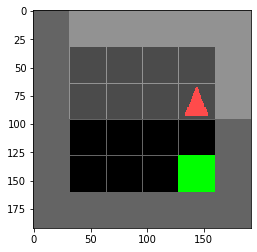

In [11]:
import gym
import matplotlib.pyplot as plt
%matplotlib inline
env = gym.make('MiniGrid-Empty-Random-6x6-v0')
# env.seed(108)
obs = env.reset()
# print(env.render(mode='rgb_array'))

plt.imshow(env.render(mode='rgb_array')); plt.show()


In [12]:
_, R, done, _ = env.step(env.action_space.sample())
print(R,done)
plt.imshow(resize(env.render(mode='rgb_array'), (80,80), anti_aliasing=False)); plt.show()
plt.imshow(env.render(mode='rgb_array')); plt.show()

0 False


NameError: name 'resize' is not defined

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
class thetaNet(nn.Module):

    def __init__(self, h=80, w=80, outputs=16):
        super(thetaNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 16, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(16)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 16
        self.head = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))
    
class alphaNet(nn.Module):

    def __init__(self, in_size=16, actions=3):
        super(alphaNet, self).__init__()
        self.head11 = nn.Linear(in_size, in_size)
        self.head12 = nn.Linear(in_size, in_size)
        self.head21 = nn.Linear(in_size, in_size)
        self.head22 = nn.Linear(in_size, in_size)
        self.head31 = nn.Linear(in_size, in_size)
        self.head32 = nn.Linear(in_size, in_size)
        self.actions = actions

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x1 = F.relu(self.head12(F.relu(self.head11(x))))
        x2 = F.relu(self.head22(F.relu(self.head11(x))))
        x3 = F.relu(self.head32(F.relu(self.head11(x))))
        x = torch.cat((x1, x2, x3), 1)
        return x.view(x.size(0), self.actions, -1)
    
class wNet(nn.Module):

    def __init__(self, in_size=16):
        super(wNet, self).__init__()
        self.head = nn.Linear(in_size, 1)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        return self.head(x)

In [21]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [22]:
net = thetaNet()
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

get_n_params(net)

22880

In [23]:
tnet = thetaNet(); anet = alphaNet(); wnet = wNet(); 

tw_params = list(tnet.parameters()) + list(wnet.parameters())
ta_params = list(tnet.parameters()) + list(anet.parameters())
optimizer1 = optim.Adam(tw_params, lr=0.001)
optimizer2 = optim.Adam(ta_params, lr=0.001)
memory = ReplayMemory(1000)

In [29]:
steps_done = 0
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

def select_action(phi, w):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
#             return policy_net(state).max(1)[1].view(1, 1)
            aout = anet(phi)
            return aout.matmul(w).max(1)[1] #maybe add .view(1,1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

In [15]:
tout = tnet(torch.zeros(8,3,80,80))
aout = anet(tout)
wout = wnet(tout)
print(tout.shape, aout.shape, wout.shape)
# need to do this: aout.matmul(wnet.head.weight.data.view(-1,1))
# and find max from there. 
print(aout.matmul(wnet.head.weight.data.view(-1,1)).max(1)[1])

NameError: name 'tnet' is not defined

In [14]:
def get_screen(env):
    k = env.render(mode='rgb_array')
    k = resize(k, (80,80), anti_aliasing=False)
    k = torch.Tensor(k)
    k = k.permute(2,1,0).unsqueeze(0)
    return k

(256, 256, 3)


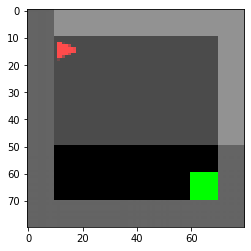

In [13]:
from gym_minigrid.envs import EmptyEnv
from skimage.transform import resize
import matplotlib.pyplot as plt
from itertools import count

env = EmptyEnv()
k = env.render(mode='rgb_array')
print(k.shape)
plt.imshow(resize(k, (80,80), anti_aliasing=False))

# Main code

In [37]:
# Initializations: Line 1
num_episodes = 1 # CHANGE
n_actions = 3
R_eps = []
ed = []

for i_episode in range(num_episodes): # Line 2
    
    R = 0
    
    # Initialize the environment and state: Line 3
    env.reset() # <TODO: random initial location>
    state = get_screen(env)
    
    for t in count(): # Line 4
        
        # Find abstracted states: Line 5
        phi = tnet(state)
        
        # Select an action: Line 6
        action = select_action(phi, wnet.head.weight.data.view(-1,1))
        
        # Perform an action: Line 7
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        R = R + reward
        next_state = get_screen(env)
        
        # Store the transition in memory: Line 8
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Lines 9 - 11
        optimize_model() # TODO
        
        # Additional tracking
        if done:
            ed.append(t+1)
            R_eps.append(R)
            break

In [36]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()